In [8]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.lines
import matplotlib as mpl
import sklearn.manifold
import sklearn.decomposition
import sklearn.cluster
import sklearn.svm
import h5py
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import cm
import pandas as pd

## Health Aging

In [2]:
ckpt_path = '../ckpt/LAB/'
time_label = 'LSP/2021_2_24_15_27'  # ls=1024, bs=64   
data_train = h5py.File(ckpt_path+time_label+'/result_train/results_allbatch.h5', 'r')
data = h5py.File(ckpt_path+time_label+'/result_test/results_alldataset.h5', 'r')

In [3]:
label_raw = np.array(data['label']).astype(int)
label_raw = (label_raw > 0).astype(int)
z1_raw = np.array(data['z1'])
z2_raw = np.array(data['z2'])
interval_raw = np.array(data['interval'])
age_raw = np.array(data['age'])
delta_z_raw = (z2_raw - z1_raw) / np.expand_dims(interval_raw, 1)

label_raw_train = np.array(data_train['label']).astype(int)
label_raw_train = (label_raw_train > 0).astype(int)
z1_raw_train = np.array(data_train['z1'])
z2_raw_train = np.array(data_train['z2'])
interval_raw_train = np.array(data_train['interval'])
age_raw_train = np.array(data_train['age'])
delta_z_raw_train = (z2_raw_train - z1_raw_train) / np.expand_dims(interval_raw_train, 1)

In [4]:
# PCA on train set and apply on test set
idx_sel = np.sort(np.where(interval_raw_train>1)[0])
num_sel = idx_sel.shape[0]

feats = np.concatenate([z1_raw_train[idx_sel], z2_raw_train[idx_sel]], 0)
pca = sklearn.decomposition.PCA(n_components=2)
zs = pca.fit_transform(feats)
z1 = zs[:num_sel]
z2 = zs[num_sel:2*num_sel]
label = label_raw_train[idx_sel]
age = age_raw_train[idx_sel]
delta_z = (z2 - z1) / np.expand_dims(interval_raw_train[idx_sel], 1)

num_sel_test = z1_raw.shape[0]
feats_test = np.concatenate([z1_raw, z2_raw], 0)
zs_test = pca.transform(feats_test)
z1_test = zs_test[:num_sel_test]
z2_test = zs_test[num_sel_test:2*num_sel_test]
label_test = label_raw
age_test = age_raw
delta_z_test = (z2_test - z1_test) / np.expand_dims(interval_raw, 1)

In [11]:
# fit curve by LME
data_fit = {'y': np.concatenate([z1[:,1], z1[:,1]+delta_z[:,1]], 0), 
            'x': np.concatenate([z1[:,0], z1[:,0]+delta_z[:,0]], 0), 
            'subj': np.concatenate([idx_sel, idx_sel], 0)}
data_fit['x2'] = data_fit['x']**2
md = smf.mixedlm("y ~ x + x2", data_fit, groups=data_fit["subj"], re_formula="~x")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())


/home/jiahong/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/jiahong/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/jiahong/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 165.939505
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: y        
No. Observations:  990     Method:             REML     
No. Groups:        495     Scale:              0.0284   
Min. group size:   2       Log-Likelihood:     -829.8905
Max. group size:   2       Converged:          No       
Mean group size:   2.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.070    0.049 -1.437 0.151 -0.166  0.026
x             -0.002    0.014 -0.117 0.906 -0.030  0.026
x2             0.004    0.002  1.990 0.047  0.000  0.008
Group Var      0.955    0.398                           
Group x x Cov  0.095    0.063                           
x Var          0.038                                    



/home/jiahong/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [12]:
# linear mixed effect model, robust version is computed in R
x_line = np.linspace(np.min(z1[:,0]), np.max(z1[:,0]))
y_line = -0.07 - 0.002 * x_line + 0.004 * x_line**2

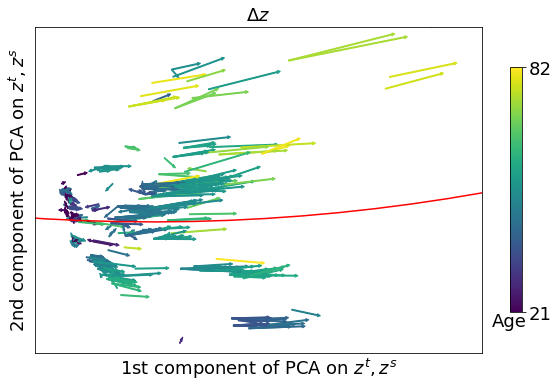

In [13]:
np.random.seed(2)
color_list = np.array(['c', 'm'])
class_list = ['NC', 'AUD']
age_max, age_min = 80, 30
age_range = age_max - age_min
age = np.clip(age, a_min=age_min, a_max=age_max)

plt.figure(figsize=(10,6))
idx_sel_list = np.arange(z1.shape[0])
for idx in idx_sel_list:
    plt.arrow(z1[idx,0], z1[idx,1], delta_z[idx,0], delta_z[idx,1], width=0.03, color=cm.viridis((age[idx]-age_min)/age_range))
plt.plot(x_line, y_line, 'r')
plt.xlim(-5, 15)
plt.ylim(-4, 5.8)
plt.title('$\Delta z$', fontsize=18)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
cbar = plt.colorbar(cm.ScalarMappable(cmap='viridis'), ticks=[0,1.0], shrink=0.75)
cbar.ax.set_yticklabels(['21', '82'], fontsize=18)
cbar.set_label('Age', labelpad=-43, y=-0., rotation=0, fontsize=18)
plt.xlabel('1st component of PCA on $z^t, z^s$', fontsize=18)
plt.ylabel('2nd component of PCA on $z^t, z^s$', fontsize=18)
plt.savefig('figure_LAB_train.png')

## ADNI

In [14]:
ckpt_path = '../ckpt/ADNI/'
time_label = 'LSP/2021_2_1_10_3'  # ls=1024, bs=64
data_train = h5py.File(ckpt_path+time_label+'/result_train/results_allbatch.h5', 'r')
data = h5py.File(ckpt_path+time_label+'/result_test/results_alldataset.h5', 'r')

In [17]:
img1 = data['img1']
img2 = data['img2']
recon1 = data['recon1']
label_raw = np.array(data['label']).astype(int)
z1_raw = np.array(data['z1'])
z2_raw = np.array(data['z2'])
interval_raw = np.array(data['interval'])
age_raw = np.array(data['age'])
delta_z_raw = (z2_raw - z1_raw) / np.expand_dims(interval_raw, 1)

label_raw_train = np.array(data_train['label']).astype(int)
z1_raw_train = np.array(data_train['z1'])
z2_raw_train = np.array(data_train['z2'])
interval_raw_train = np.array(data_train['interval'])
age_raw_train = np.array(data_train['age'])
delta_z_raw_train = (z2_raw_train - z1_raw_train) / np.expand_dims(interval_raw_train, 1)

In [19]:
# PCA on train set and apply on test set
num_sel = np.where(interval_raw_train>0.5)[0].shape[0]
idx_sel = np.where(interval_raw_train>0.5)[0]
feats = np.concatenate([z1_raw_train[idx_sel], z2_raw_train[idx_sel]], 0)
pca = sklearn.decomposition.PCA(n_components=2)
zs = pca.fit_transform(feats)
z1 = zs[:num_sel]
z2 = zs[num_sel:2*num_sel]
delta_z = (z2 - z1) / np.expand_dims(interval_raw_train[idx_sel], 1)
label = label_raw_train[idx_sel]
age = age_raw_train[idx_sel]

num_sel_test = z1_raw.shape[0]
feats_test = np.concatenate([z1_raw, z2_raw], 0)
zs_test = pca.transform(feats_test)
z1_test = zs_test[:num_sel_test]
z2_test = zs_test[num_sel_test:2*num_sel_test]
delta_z_test = (z2_test - z1_test) / np.expand_dims(interval_raw, 1)
label_test = label_raw
age_test = age_raw

In [20]:
# fit curve by LME
data_fit = {'y': z1[:,1], 'x': z1[:,0], 'x2': z1[:,0]**2, 'subj': idx_sel}
md = smf.mixedlm("y ~ x + x2", data_fit, groups=data_fit["subj"], re_formula="~x")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/home/jiahong/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: y         
No. Observations:  2562    Method:             REML      
No. Groups:        2562    Scale:              0.5851    
Min. group size:   1       Log-Likelihood:     -4340.0773
Max. group size:   1       Converged:          Yes       
Mean group size:   1.0                                   
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -0.520    0.037 -13.941 0.000 -0.593 -0.447
x             -0.021    0.002  -8.936 0.000 -0.026 -0.016
x2             0.003    0.000  17.725 0.000  0.002  0.003
Group Var      1.334                                     
Group x x Cov  0.041                                     
x Var          0.002                                     



In [25]:
# linear mixed effect model, robust version is computed in R
x_line = np.linspace(np.min(z1[:,0]), np.max(z1[:,0]))
# y_line = -0.383 - 0.017 * x_line + 0.002 * x_line**2
y_line = -0.52 - 0.021 * x_line + 0.003 * x_line**2

-26.461952209472656 43.2308464050293 -5.792330741882324 6.165668964385986


No handles with labels found to put in legend.


Text(0, 0.5, '2nd component of PCA on $z^t, z^s$')

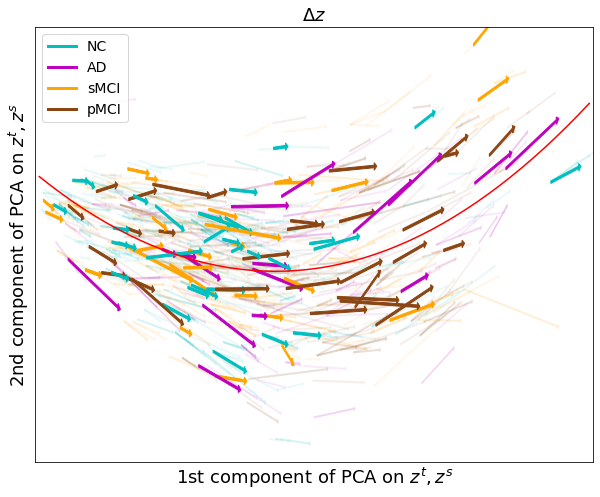

In [26]:
# training set
np.random.seed(2)
# color_list = np.array(['c', 'k', 'm', 'y', 'b'])
color_list = np.array(['c', 'k', 'm', 'orange', 'saddlebrown'])
class_list = ['NC', 'MCI', 'AD', 'sMCI', 'pMCI']
plt.figure(figsize=(10,8))
if z1.shape[0] > 100:
    idx_sel_list = np.random.choice(z1.shape[0], z1.shape[0]//2)
else:
    idx_sel_list = np.arange(z1.shape[0])
x_min = min(np.min(z1[:,0]), np.min(z1[:,0]+delta_z[:,0])) - 0.5
x_max = min(np.max(z1[:,0]), np.max(z1[:,0]+delta_z[:,0])) + 0.5
y_min = min(np.min(z1[:,1]), np.min(z1[:,1]+delta_z[:,1])) - 0.5
y_max = min(np.max(z1[:,1]), np.max(z1[:,1]+delta_z[:,1])) + 0.5
print(x_min, x_max, y_min, y_max)

for idx in idx_sel_list:
    plt.arrow(z1[idx,0], z1[idx,1], delta_z[idx,0], delta_z[idx,1], width=(x_max-x_min)*0.0005, color=color_list[label[idx]], alpha=0.05)
idx_sel_list = np.random.choice(z1.shape[0], 100)
for idx in idx_sel_list:
    plt.arrow(z1[idx,0], z1[idx,1], delta_z[idx,0], delta_z[idx,1], width=(x_max-x_min)*0.001, color=color_list[label[idx]])    
ad_idx = np.where(label==2)[0]

plt.legend()
plt.plot(x_line, y_line, 'r')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('$\Delta z$', fontsize=18)
colors = ['c', 'm', 'orange', 'saddlebrown']
lines = [matplotlib.lines.Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['NC', 'AD', 'sMCI', 'pMCI']
plt.legend(lines, labels, prop={'size': 14})
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlabel('1st component of PCA on $z^t, z^s$', fontsize=18)
plt.ylabel('2nd component of PCA on $z^t, z^s$', fontsize=18)

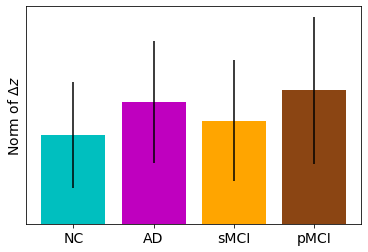

In [28]:
x = ['NC', 'AD', 'sMCI', 'pMCI']
color_list = np.array(['c', 'm', 'orange', 'saddlebrown'])
norm_delta_z = np.sqrt(np.sum(delta_z**2, 1))

mean = [np.mean(norm_delta_z[label==0]), np.mean(norm_delta_z[label==2]), np.mean(norm_delta_z[label==3]), np.mean(norm_delta_z[label==4])]
std = [np.std(norm_delta_z[label==0]), np.std(norm_delta_z[label==2]), np.std(norm_delta_z[label==3]), np.std(norm_delta_z[label==4])]
x_pos = [i for i, _ in enumerate(x)]

for i in range(4):
    plt.bar(i, mean[i], color=color_list[i], yerr=std[i])
plt.ylabel('Norm of ' + r'$\Delta z$', fontsize=14)
plt.xticks(x_pos, x, fontsize=14)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.show()

Text(0, 0.5, '2nd component of PCA on $z^t, z^s$')

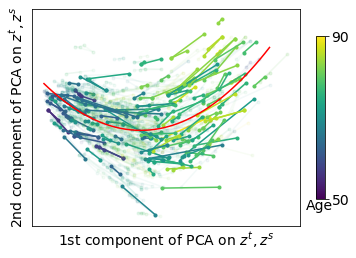

In [40]:
txtfile = pd.read_csv('../data/ADNI/fold0_train_NC_AD_pMCI_sMCI.txt', sep=' ', header=None)
idx_sel = np.where(interval_raw_train>0.5)[0]
pairs = np.array(txtfile[[3,4]].iloc[idx_sel])

np.random.seed(0)
age_max, age_min = 90, 50
age_range = age_max - age_min

for idx in range(idx_sel.shape[0]):
    if pairs[idx,1] - pairs[idx,0] > 1:
        continue
    plt.plot([z1[idx,0],z2[idx,0]], [z1[idx,1],z2[idx,1]], '.-', color=cm.viridis((age[idx]-age_min)/age_range), alpha=0.05)
    if age[idx] < 80:
        if np.random.rand() > 0.85:
            plt.plot([z1[idx,0],z2[idx,0]], [z1[idx,1],z2[idx,1]], '.-', color=cm.viridis((age[idx]-age_min)/age_range))
    if age[idx] > 80:
        if np.random.rand() > 0.6:
            plt.plot([z1[idx,0],z2[idx,0]], [z1[idx,1],z2[idx,1]], '.-', color=cm.viridis((age[idx]-age_min)/age_range))
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
cbar = plt.colorbar(cm.ScalarMappable(cmap='viridis'), ticks=[0,1.0], shrink=0.75)
cbar.ax.set_yticklabels(['50', '90'], fontsize=14)
cbar.set_label('Age', labelpad=-30, y=-0., rotation=0, fontsize=14)
plt.plot(x_line, y_line, 'r')
plt.xlabel('1st component of PCA on $z^t, z^s$', fontsize=14)
plt.ylabel('2nd component of PCA on $z^t, z^s$', fontsize=14)